# NASA: Asteroids Classification

**Acest Notebook a fost generat de ChatGPT astfel**  
**- secventele de cod .... %**  
**- comentariile .... %**  
**Conributia personala a constat în ......................** 
**Valorile procentuale de mai sus sunt aproximative dar reflectă în esență adevărul.**

### 1. Descrierea problemei

[Acesta](https://www.kaggle.com/datasets/shrutimehta/nasa-asteroids-classification/data?select=nasa.csv) este un set de date colectat de la NASA API, care conține informații despre asteroizi. Fiecare rând este un asteroid, iar fiecare coloană este o caracteristică a lui.  
Coloanele din acest dataset sunt:  
1. Neo Reference ID – identificator unic al asteroidului în baza de date NASA

2. Name – numele sau denumirea asteroidului

3. Absolute Magnitude – mărimea absolută a asteroidului, un indicator al luminozității sale

4. Est Dia in KM(min/max) – estimarea diametrului asteroidului în kilometri (valoarea minimă și maximă)

5. Est Dia in M(min/max) – estimarea diametrului în metri

6. Est Dia in Miles(min/max) – estimarea diametrului în mile

7. Est Dia in Feet(min/max) – estimarea diametrului în picioare

8. Close Approach Date – data la care asteroidul se apropie cel mai mult de Pământ

9. Epoch Date Close Approach – timestamp al acelei date

10. Relative Velocity (km/sec, km/hr, miles/hr) – viteza relativă a asteroidului față de Pământ în diferite unități

11. Miss Dist. (Astronomical, lunar, kilometers, miles) – distanța de „trecere pe lângă” Pământ, exprimată în unități astronomice, 
distanța lunară, kilometri și mile

12. Orbiting Body – corpul ceresc în jurul căruia orbitează asteroidul (Pământul)

13. Orbit ID – identificator al orbitelor calculate

14. Orbit Determination Date – data la care au fost determinate aceste caracteristici orbitale

15. Orbit Uncertainty – măsura incertitudinii în determinarea orbitei

16. Minimum Orbit Intersection – distanța minimă la care orbita asteroidului intersectează orbita Pământului

17. Jupiter Tisserand Invariant – o constantă orbitală ce ajută la clasificarea obiectelor în Sistemul Solar

18. Epoch Osculation – momentul de timp la care sunt calculate elementele orbitale

19. Eccentricity – cât de eliptică este orbita asteroidului

20. Semi Major Axis – distanța medie față de Soare pe orbită

21. Inclination – unghiul orbitei față de planul eclipticii

22. Asc Node Longitude – longitudinea nodului ascendent al orbitei

23. Orbital Period – perioada orbitală în zile

24. Perihelion Distance – distanța minimă față de Soare

25. Perihelion Arg – argumentul perihelionului (un unghi orbital)

26. Aphelion Distance – distanța maximă față de Soare

27. Perihelion Time – momentul când asteroidul ajunge la perihelion

28. Mean Anomaly – unghi orbital ce indică poziția asteroidului pe orbită

29. Mean Motion – viteza medie orbitală

30. Equinox – referința temporală pentru coordonate

31. Hazardous – variabilă țintă, 1 dacă asteroidul este periculos pentru Pământ, 0 dacă nu  

Având această ultimă coloană, problema este una de clasificare supravegheată, în care trebuie prezis dacă un asteroid este „Periculos” sau „Nepericulos”.

Așadar, obiectivul problemei este de a construi un model care, dat un set de caracteristici ale unui asteroid, prezice dacă este periculos sau nu.

### 2. Citirea setului de invățare și importarea bibliotecilor necesare

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Încărcarea setului de învățare
df = pd.read_csv("nasa.csv")

### 3. Preprocesarea datelor

Explorarea inițială a datelor

In [28]:
print(f"Dataset shape: {df.shape}")
print(f"Coloane: {len(df.columns)}")
print(f"Valori lipsă: {df.isnull().sum().sum()}")
print(f"Linii duplicate: {df.duplicated().sum()}")
print(f"Memoria utilizată: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColoanele:")
df.info()

Dataset shape: (4687, 40)
Coloane: 40
Valori lipsă: 0
Linii duplicate: 0
Memoria utilizată: 2.31 MB

Coloanele:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close App

In [29]:
# Tipuri de date
print(f"\nDistribuția tipurilor de date:")
print(df.dtypes.value_counts())


Distribuția tipurilor de date:
float64    30
int64       5
object      4
bool        1
Name: count, dtype: int64


Distribuția în funcție de pericol:

In [30]:
hazard_counts = df['Hazardous'].value_counts()
print(hazard_counts)
print(f"\nRația nepericol-pericol: {hazard_counts[False] / hazard_counts[True]:.2f}:1")

Hazardous
False    3932
True      755
Name: count, dtype: int64

Rația nepericol-pericol: 5.21:1


In [31]:
# Primele 5 observații
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


Scoaterea caracteristicilor inutile

In [32]:
df_clean = df.copy()

# Caracteristici neimportante, care sunt ID-uri sau date calendaristice
id_cols = ['Neo Reference ID', 'Name', 'Orbit ID', 'Close Approach Date', 
            'Epoch Date Close Approach', 'Orbit Determination Date']

# Caracteristici categorice
categorical_cols = ['Orbiting Body', 'Equinox']

#Eliminarea acestor caracteristici
cols_to_remove = [col for col in id_cols + categorical_cols if col in df_clean.columns]
df_clean = df_clean.drop(cols_to_remove, axis=1)

df_clean.head()

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Relative Velocity km per sec,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,6.115834,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,18.113985,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,7.590711,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,11.173874,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,9.840831,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True


Scoatem catacteristicile care se repeta, diferența fiind unitatea de măsură în care sunt prezente datele. Nu avem nevoie decât de câte una din fiecare, altfel am avea caracteristici cu un coeficient foarte mare de corelatie, ceea ce nu ne-ar ajuta.  

De asemenea, v-om converti și țintea din boolean în int, pentru a putea fi utilizată în model.

In [33]:
# Convertirea țintei din boolean în int
df_clean['Hazardous'] = df_clean['Hazardous'].astype(int)

# Eliminarea caracteristicilor de diametru care sunt redundante, păstrăm doar Est Dia in KM(max)
df_clean = df_clean.drop(['Est Dia in KM(min)', 'Est Dia in M(min)', 'Est Dia in M(max)',
                          'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)',
                          'Est Dia in Feet(max)'],axis=1)

# Eliminarea caracteristicilor de viteza care sunt redundante, păstrăm doar Relative Velocity km per sec
df_clean = df_clean.drop(['Relative Velocity km per hr','Miles per hour'],axis=1)

# Eliminarea caracteristicilor de distanță care sunt redundante, păstrăm doar Miss Dist.(Astronomical)
df_clean = df_clean.drop(['Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)'],axis=1)

df_processed = df_clean

print(f'Dimensiunea setului de date procesate: {df_processed.shape}')

df_processed.head()

Dimensiunea setului de date procesate: (4687, 20)


,Absolute Magnitude,Est Dia in KM(max),Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.6,0.284472,6.115834,0.419483,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,1
1,21.3,0.326618,18.113985,0.383014,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,0
2,20.3,0.517654,7.590711,0.050956,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,1
3,27.4,0.019681,11.173874,0.285322,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,0
4,21.6,0.284472,9.840831,0.407832,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,1


### 4. Analiza Explorativă a Datelor

Separăm setul de date de intrare de setul țintă

In [34]:
X = df_processed.drop('Hazardous', axis=1)
y = df_processed['Hazardous']

print(f"Shape-ul matricii caracteristicilor: {X.shape}")
print(f"Shape-ul vectorului target: {y.shape}")

Shape-ul matricii caracteristicilor: (4687, 19)
Shape-ul vectorului target: (4687,)


In [35]:
X.describe()

,Absolute Magnitude,Est Dia in KM(max),Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
count,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000
mean,22.267865,0.457509,13.970811,0.256778,3.516962,0.082320,5.056111,2.457724e+06,0.382569,1.400264,13.373844,172.157275,635.582076,0.813383,183.932151,1.987144,2.457728e+06,181.167927,0.738242
std,2.890972,0.826391,7.293223,0.145798,3.078307,0.090300,1.237818,9.202975e+02,0.180444,0.524154,10.936227,103.276777,370.954727,0.242059,103.513035,0.951519,9.442264e+02,107.501623,0.342627
min,11.160000,0.002260,0.335504,0.000178,0.000000,0.000002,2.196000,2.450164e+06,0.007522,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,2.450100e+06,0.003191,0.086285
25%,20.100000,0.074824,8.432865,0.133420,0.000000,0.014585,4.049500,2.458000e+06,0.240858,1.000635,4.962341,83.081208,365.605031,0.630834,95.625916,1.266059,2.457815e+06,87.006918,0.453289
50%,21.900000,0.247765,12.917889,0.265029,3.000000,0.047365,5.071000,2.458000e+06,0.372450,1.240981,10.311836,172.625393,504.947292,0.833153,189.761641,1.618195,2.457973e+06,185.718889,0.712946
75%,24.500000,0.567597,18.077649,0.384154,6.000000,0.123593,6.019000,2.458000e+06,0.512411,1.678364,19.511681,255.026909,794.195972,0.997227,271.777557,2.451171,2.458108e+06,276.531946,0.984669
max,32.100000,34.836938,44.633747,0.499884,9.000000,0.477891,9.025000,2.458020e+06,0.960261,5.072008,75.406667,359.905890,4172.231343,1.299832,359.993098,8.983852,2.458839e+06,359.917991,2.039000


Privire de ansamblu asupra dataset-ul NASA Asteroids

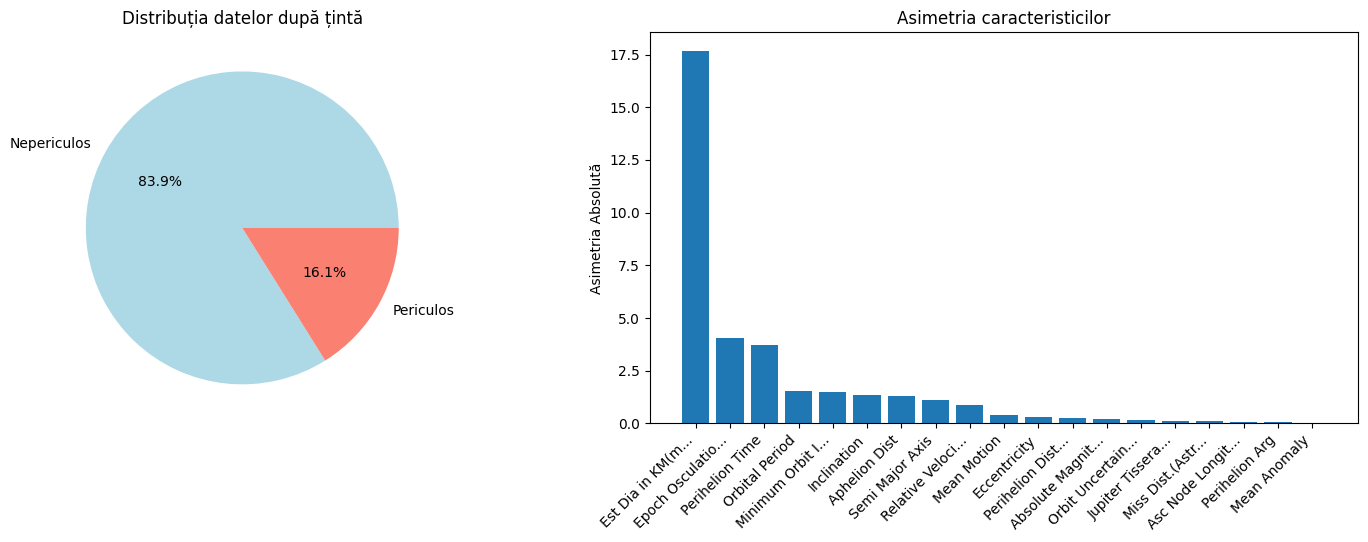

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Distribuția datelor după țintă
axes[0].pie(y.value_counts(), labels=['Nepericulos', 'Periculos'], 
            autopct='%1.1f%%', colors=['lightblue', 'salmon'])
axes[0].set_title('Distribuția datelor după țintă')

# 2. Asimetria caracteristicilor
numeric_features = X.select_dtypes(include=[np.number]).columns
asimetria = X[numeric_features].skew().abs().sort_values(ascending=False)
axes[1].bar(range(len(asimetria)), asimetria.values)
axes[1].set_xticks(range(len(asimetria)))
axes[1].set_xticklabels([col[:15] + '...' if len(col) > 15 else col 
                         for col in asimetria.index], rotation=45, ha='right')
axes[1].set_ylabel('Asimetria Absolută')
axes[1].set_title('Asimetria caracteristicilor')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


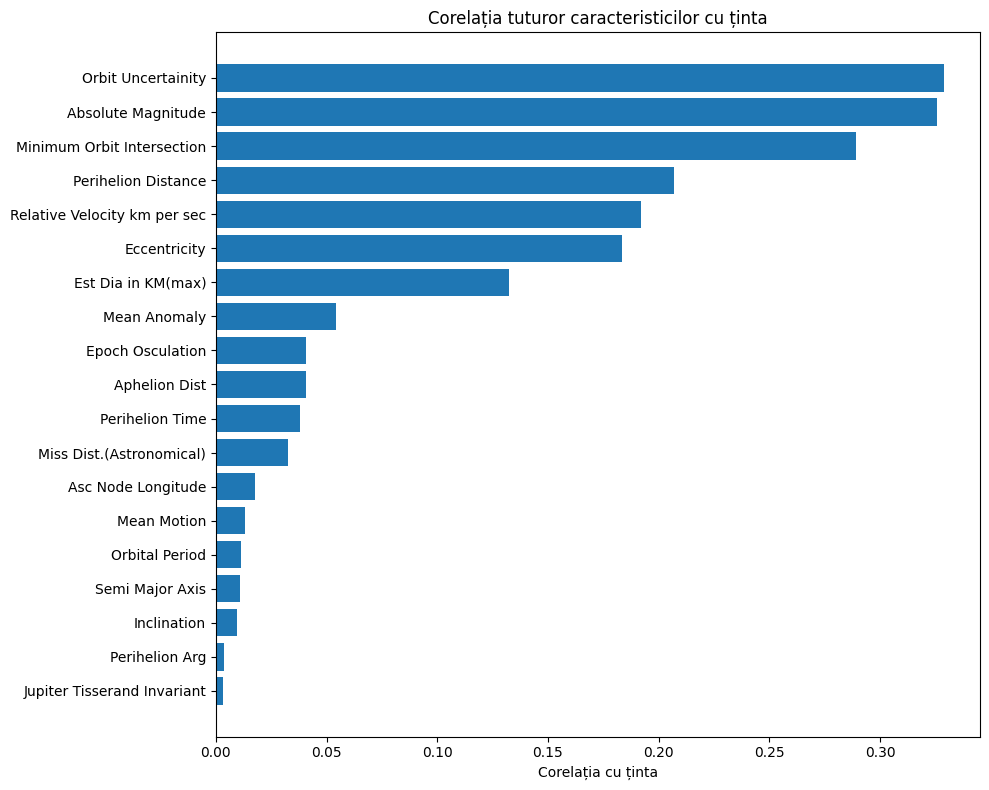

In [37]:
correlations = pd.concat([X, y], axis=1).corr()['Hazardous'].abs().sort_values(ascending=False)[1:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(correlations)), correlations.values)
plt.yticks(range(len(correlations)), 
           [col[:30] + '...' if len(col) > 30 else col for col in correlations.index])
plt.xlabel('Corelația cu ținta')
plt.title('Corelația tuturor caracteristicilor cu ținta')
plt.gca().invert_yaxis() #Cele mai corelate cu ținta sus
plt.tight_layout()
plt.show()


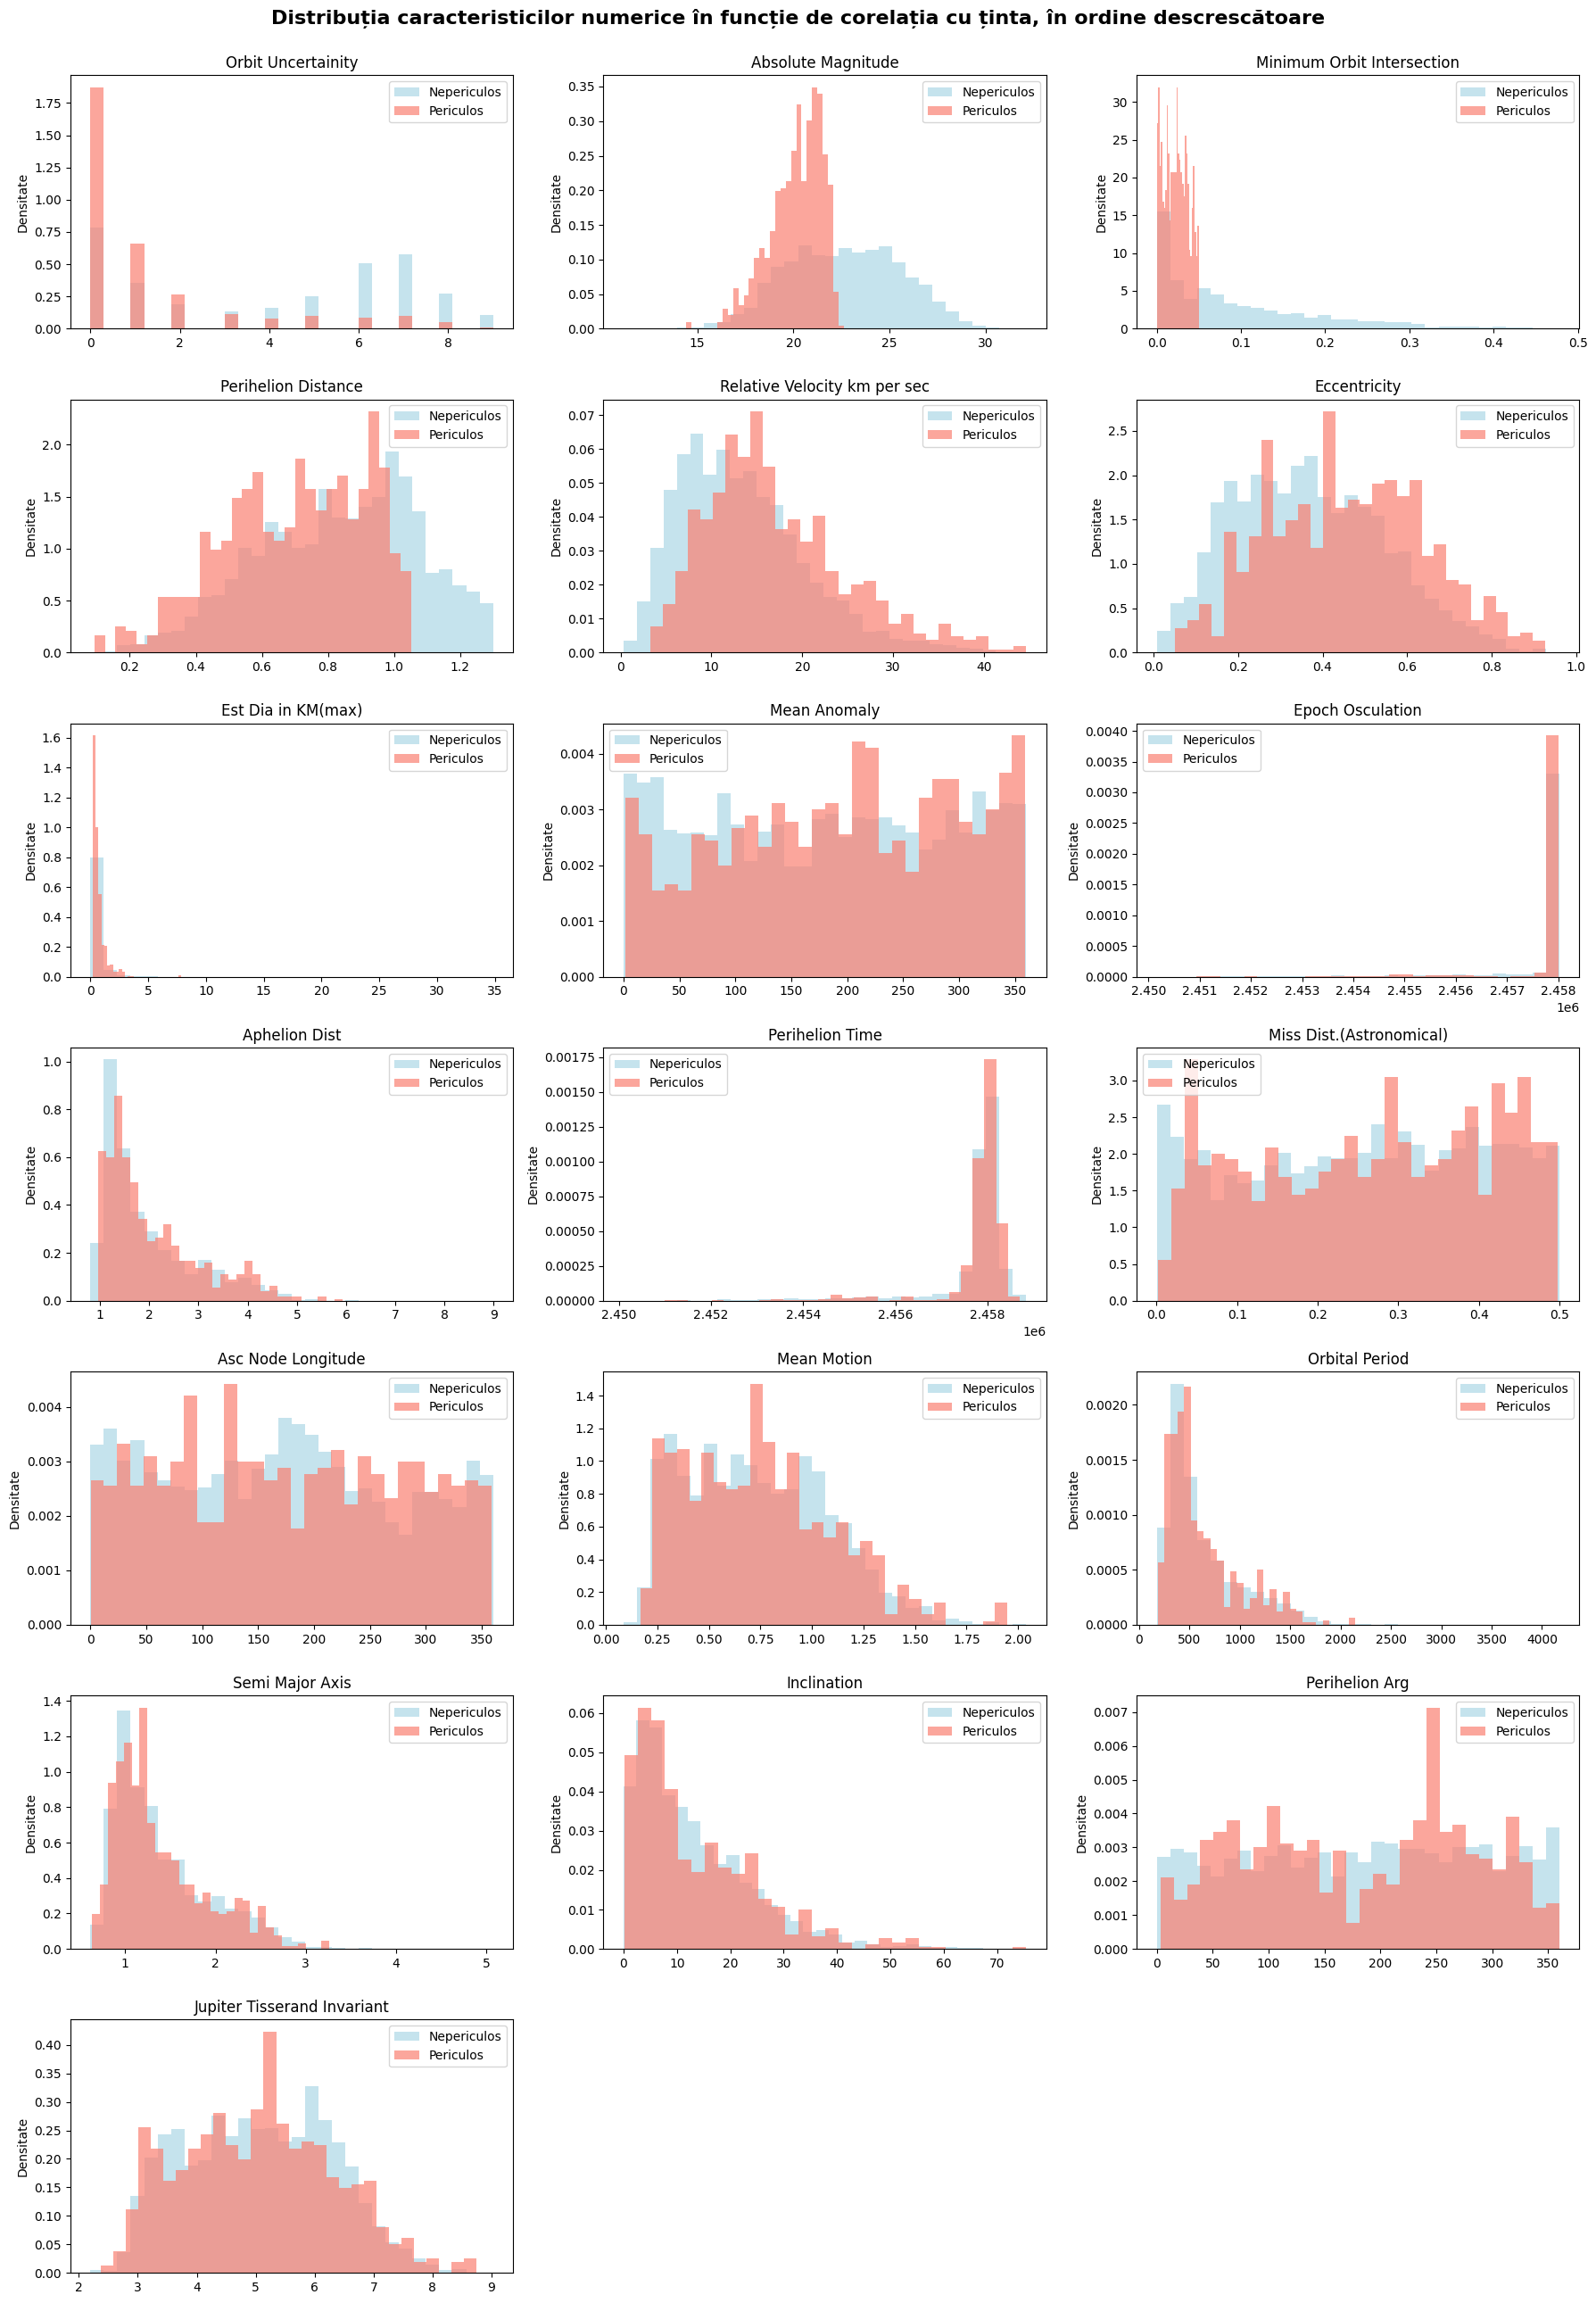

In [38]:
# Calculăm corelațiile cu ținta și sortăm descrescător
correlations = pd.concat([X, y], axis=1).corr()['Hazardous'].abs().sort_values(ascending=False)[1:]
numeric_features_sorted = [feat for feat in correlations.index if feat in X.select_dtypes(include=[np.number]).columns]

num_features = len(numeric_features_sorted)
cols = 3  # număr de coloane în figura de subgrafice
rows = int(np.ceil(num_features / cols))

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
fig.suptitle('Distribuția caracteristicilor numerice în funcție de corelația cu ținta, în ordine descrescătoare', 
             fontsize=16, fontweight='bold', y=0.95)

for i, feature in enumerate(numeric_features_sorted):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]

    hazardous_data = X[y == 1][feature]
    non_hazardous_data = X[y == 0][feature]

    ax.hist(non_hazardous_data, alpha=0.7, label='Nepericulos',
            bins=30, color='lightblue', density=True)
    ax.hist(hazardous_data, alpha=0.7, label='Periculos',
            bins=30, color='salmon', density=True)
    
    ax.set_title(f'{feature[:30]}...' if len(feature) > 30 else feature)
    ax.set_ylabel('Densitate')
    ax.legend()

# Elimină subplot-urile goale (dacă e cazul)
if rows * cols > num_features:
    for j in range(num_features, rows * cols):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


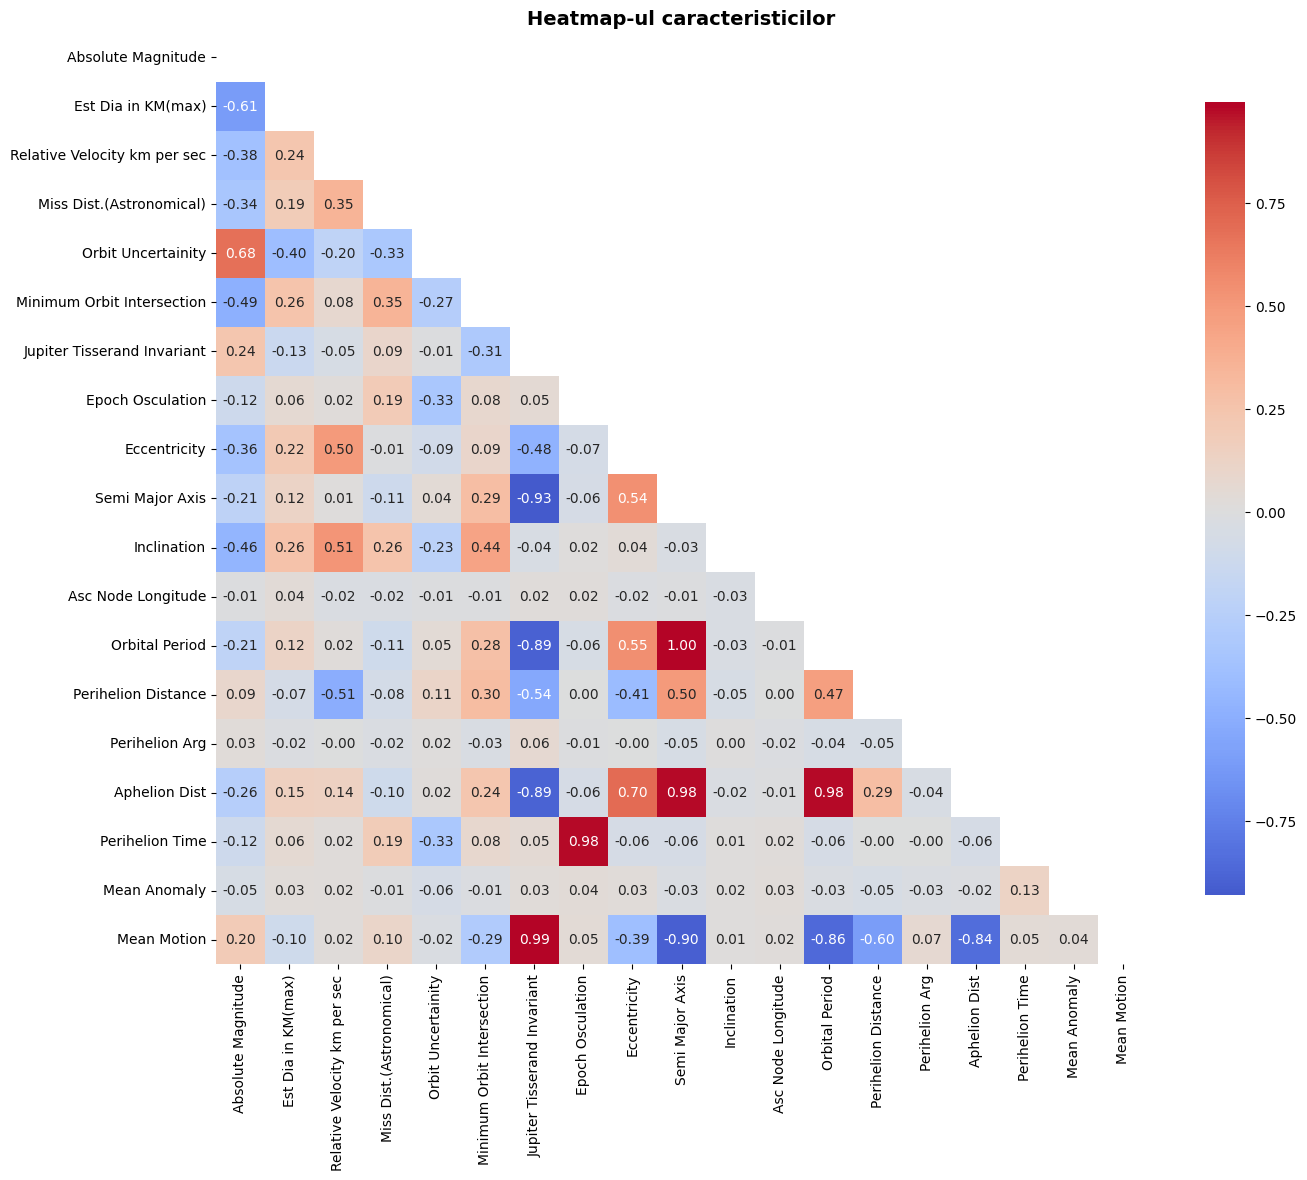

In [39]:
# Heatmap-ul pentru toate caracteristicile
plt.figure(figsize=(14, 12))
corr_matrix = X.corr()

# Crează o mască pentru triunghiul superior (pentru claritate)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Afișează heatmap-ul
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})

# Titlul graficului în română
plt.title('Heatmap-ul caracteristicilor', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Analiza valorilor atipice

In [40]:
Q1 = X.quantile(0.25) # Primul cvartil (25%)
Q3 = X.quantile(0.75) # Al treilea cvartil (75%)
IQR = Q3 - Q1 # Intervalul intercvartilic
outliers = ((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).sum()
print("Numărul valorilor atipice per caracteristică (>3 IQR):")
for feature, count in outliers[outliers > 0].items():
    print(f"  {feature}: {count} valori atipice ({count/len(X)*100:.1f}%)")

Numărul valorilor atipice per caracteristică (>3 IQR):
  Est Dia in KM(max): 142 valori atipice (3.0%)
  Minimum Orbit Intersection: 5 valori atipice (0.1%)
  Epoch Osculation: 639 valori atipice (13.6%)
  Semi Major Axis: 2 valori atipice (0.0%)
  Inclination: 6 valori atipice (0.1%)
  Orbital Period: 14 valori atipice (0.3%)
  Aphelion Dist: 4 valori atipice (0.1%)
  Perihelion Time: 405 valori atipice (8.6%)


### 5. Alegerea caracteristicilor și compararea metodelor de preprocesare

Împărțirea datelor în seturi de antrenare și testare

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Setul de antrenare: {X_train.shape}")
print(f"Setul de testare: {X_test.shape}")

Setul de antrenare: (3749, 19)
Setul de testare: (938, 19)


Selecția celor mai bune caracteristici bazată pe metode statistice

In [42]:
# Metoda 1: F-statistic
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X_train, y_train)
f_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': selector_f.scores_,
    'P_Value': selector_f.pvalues_
}).sort_values('F_Score', ascending=False)
print(f_scores)

                         Feature     F_Score       P_Value
4             Orbit Uncertainity  475.001405  2.994320e-99
0             Absolute Magnitude  458.408735  4.865396e-96
5     Minimum Orbit Intersection  333.107097  2.296390e-71
13           Perihelion Distance  159.719022  6.964754e-36
2   Relative Velocity km per sec  152.551244  2.221032e-34
8                   Eccentricity  122.908910  3.978532e-28
1             Est Dia in KM(max)   67.420916  2.985791e-16
17                  Mean Anomaly   12.358230  4.442468e-04
7               Epoch Osculation   11.710096  6.282757e-04
16               Perihelion Time   10.216176  1.403711e-03
15                 Aphelion Dist    6.750327  9.409755e-03
3       Miss Dist.(Astronomical)    6.630647  1.006191e-02
10                   Inclination    1.426523  2.324083e-01
11            Asc Node Longitude    1.235988  2.663171e-01
18                   Mean Motion    0.468809  4.935779e-01
12                Orbital Period    0.309383  5.780925e-

In [43]:
# Metoda 2: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_train, y_train)
mi_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)
print('\n',mi_scores)


                          Feature  MI_Score
5     Minimum Orbit Intersection  0.163951
1             Est Dia in KM(max)  0.122347
0             Absolute Magnitude  0.120356
13           Perihelion Distance  0.091518
6    Jupiter Tisserand Invariant  0.076843
8                   Eccentricity  0.076768
15                 Aphelion Dist  0.075027
4             Orbit Uncertainity  0.068173
14                Perihelion Arg  0.067963
11            Asc Node Longitude  0.064405
10                   Inclination  0.063550
12                Orbital Period  0.056707
9                Semi Major Axis  0.056545
18                   Mean Motion  0.056082
17                  Mean Anomaly  0.055169
16               Perihelion Time  0.050388
2   Relative Velocity km per sec  0.024606
3       Miss Dist.(Astronomical)  0.009758
7               Epoch Osculation  0.000000


Din încercări, pentru a limita overfitting-ul, am ales să folosesc 8 caracteristici. Inițial alesesem 7 caracteristici.

In [44]:
n_features = 8

# Combinăm cele mai bune 8 caracteristici din ambele metode
top_f = set(f_scores.head(n_features)['Feature'].tolist())
top_mi = set(mi_scores.head(n_features)['Feature'].tolist())
selected_features = list(top_f.union(top_mi))

selected_features, f_scores, mi_scores = selected_features[:n_features], f_scores, mi_scores

print(f"\nCaracteristicile selectate ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")


Caracteristicile selectate (8):
  1. Relative Velocity km per sec
  2. Mean Anomaly
  3. Minimum Orbit Intersection
  4. Aphelion Dist
  5. Orbit Uncertainity
  6. Eccentricity
  7. Jupiter Tisserand Invariant
  8. Est Dia in KM(max)


Compararea diferitelor scalări

In [45]:
scalers = {
    'No Scaling': None,
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'PowerTransformer': PowerTransformer()
}

scaler_results = {}

# Testarea fiecărui scaler cu un model simplu
test_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nRezultatele comparării scalărilor:")
print("-"*50)

for scaler_name, scaler in scalers.items():
    if scaler is None:
        X_train_scaled = X_train[selected_features]
    else:
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train[selected_features]),
            columns=selected_features,
            index=X_train.index
        )
    
    # Cross-validarea
    cv_scores = cross_val_score(test_model, X_train_scaled, y_train, 
                               cv=cv_strategy, scoring='accuracy')
    
    scaler_results[scaler_name] = {
        'mean_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std(),
        'scaler': scaler
    }
    
    print(f"{scaler_name:15}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Rezultatele comparării scalărilor:
--------------------------------------------------
No Scaling     : 0.8266 (+/- 0.0286)
StandardScaler : 0.8661 (+/- 0.0259)
RobustScaler   : 0.8656 (+/- 0.0267)
MinMaxScaler   : 0.8493 (+/- 0.0266)
PowerTransformer: 0.9048 (+/- 0.0298)


Alegerea celei mai bune scalări

In [46]:
best_scaler_name = max(scaler_results.keys(), key=lambda x: scaler_results[x]['mean_cv_score'])
best_scaler = scaler_results[best_scaler_name]['scaler']

print(f"\nCea mai bună scalare: {best_scaler_name}")

# Aplicarea celei mai bune scalări
if best_scaler is None:
    X_train_final = X_train[selected_features]
    X_test_final = X_test[selected_features]
else:
    X_train_final = pd.DataFrame(
        best_scaler.fit_transform(X_train[selected_features]),
        columns=selected_features,
        index=X_train.index
    )
    X_test_final = pd.DataFrame(
        best_scaler.transform(X_test[selected_features]),
        columns=selected_features,
        index=X_test.index
    )


Cea mai bună scalare: PowerTransformer


### 6. Modelare de învățare automata

Alegerea modelelor

In [47]:
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', random_state=42, max_iter=1000
    ),
    'SVM (RBF)': SVC(
        class_weight='balanced', probability=True, random_state=42, 
        C=1.0, gamma='scale'
    ),
    'SVM (Linear)': SVC(
        class_weight='balanced', probability=True, random_state=42, 
        kernel='linear', C=1.0
    ),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5, weights='distance'
    ),
    'Decision Tree': DecisionTreeClassifier(
        class_weight='balanced', random_state=42, 
        max_depth=10, min_samples_split=20
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced', n_estimators=100, random_state=42,
        max_depth=15, min_samples_split=10, min_samples_leaf=5
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, random_state=42, 
        max_depth=6, learning_rate=0.1
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100, random_state=42, learning_rate=1.0
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, random_state=42, 
        max_depth=6, learning_rate=0.1
    )
}

print(models.keys())

dict_keys(['Logistic Regression', 'SVM (RBF)', 'SVM (Linear)', 'Naive Bayes', 'K-Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'XGBoost'])


Antrenarea și evaluarea tuturor modelor

In [48]:
results = {}
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print("\n" + "=" * 60)
    print(f"\n{name}:")
    print("-" * (len(name) + 1))
    
    # Cross-validarea
    cv_scores = cross_val_score(model, X_train_final, y_train, 
                               cv=cv_strategy, scoring='accuracy')
    
    # Antrenarea pe setul de învățare complet
    model.fit(X_train_final, y_train)
    
    # Preziceri
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrici
    test_accuracy = (y_pred == y_test).mean()
    test_roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Stocarea rezultatelor
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'test_roc_auc': test_roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model
    }
    
    print(f"Acuratețea CV: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Acuratețea testării: {test_accuracy:.4f}")
    if test_roc_auc:
        print(f"Test ROC-AUC: {test_roc_auc:.4f}")



Logistic Regression:
--------------------
Acuratețea CV: 0.9048 (+/- 0.0298)
Acuratețea testării: 0.8998
Test ROC-AUC: 0.9698


SVM (RBF):
----------
Acuratețea CV: 0.9475 (+/- 0.0325)
Acuratețea testării: 0.9627
Test ROC-AUC: 0.9972


SVM (Linear):
-------------
Acuratețea CV: 0.9002 (+/- 0.0287)
Acuratețea testării: 0.8977
Test ROC-AUC: 0.9692


Naive Bayes:
------------
Acuratețea CV: 0.9419 (+/- 0.0104)
Acuratețea testării: 0.9403
Test ROC-AUC: 0.9865


K-Nearest Neighbors:
--------------------
Acuratețea CV: 0.9531 (+/- 0.0103)
Acuratețea testării: 0.9648
Test ROC-AUC: 0.9730


Decision Tree:
--------------
Acuratețea CV: 0.9941 (+/- 0.0049)
Acuratețea testării: 0.9957
Test ROC-AUC: 0.9999


Random Forest:
--------------
Acuratețea CV: 0.9947 (+/- 0.0079)
Acuratețea testării: 0.9968
Test ROC-AUC: 0.9999


Gradient Boosting:
------------------
Acuratețea CV: 0.9955 (+/- 0.0052)
Acuratețea testării: 0.9925
Test ROC-AUC: 0.9927


AdaBoost:
---------
Acuratețea CV: 0.9952 (+/- 0.003

### 7. Compararea și validarea modelelor

Crearea unui DataFrame cu toate rezultatele

In [49]:
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'CV_Mean': result['cv_mean'],
        'CV_Std': result['cv_std'],
        'Test_Accuracy': result['test_accuracy'],
        'ROC_AUC': result['test_roc_auc'] if result['test_roc_auc'] else 0,
        'Overfitting': result['cv_mean'] - result['test_accuracy']
    })

results_df = pd.DataFrame(comparison_data).sort_values('Test_Accuracy', ascending=False)
print("Compararea performanțelor modelelor:")
print(results_df.round(4))

Compararea performanțelor modelelor:
                 Model  CV_Mean  CV_Std  Test_Accuracy  ROC_AUC  Overfitting
8             AdaBoost   0.9952  0.0018         0.9979   1.0000      -0.0027
6        Random Forest   0.9947  0.0040         0.9968   0.9999      -0.0021
5        Decision Tree   0.9941  0.0025         0.9957   0.9999      -0.0016
9              XGBoost   0.9944  0.0020         0.9947   0.9999      -0.0003
7    Gradient Boosting   0.9955  0.0026         0.9925   0.9927       0.0029
4  K-Nearest Neighbors   0.9531  0.0051         0.9648   0.9730      -0.0118
1            SVM (RBF)   0.9475  0.0162         0.9627   0.9972      -0.0152
3          Naive Bayes   0.9419  0.0052         0.9403   0.9865       0.0016
0  Logistic Regression   0.9048  0.0149         0.8998   0.9698       0.0050
2         SVM (Linear)   0.9002  0.0143         0.8977   0.9692       0.0026


Vizualizarea comparării performanțelor modelelor

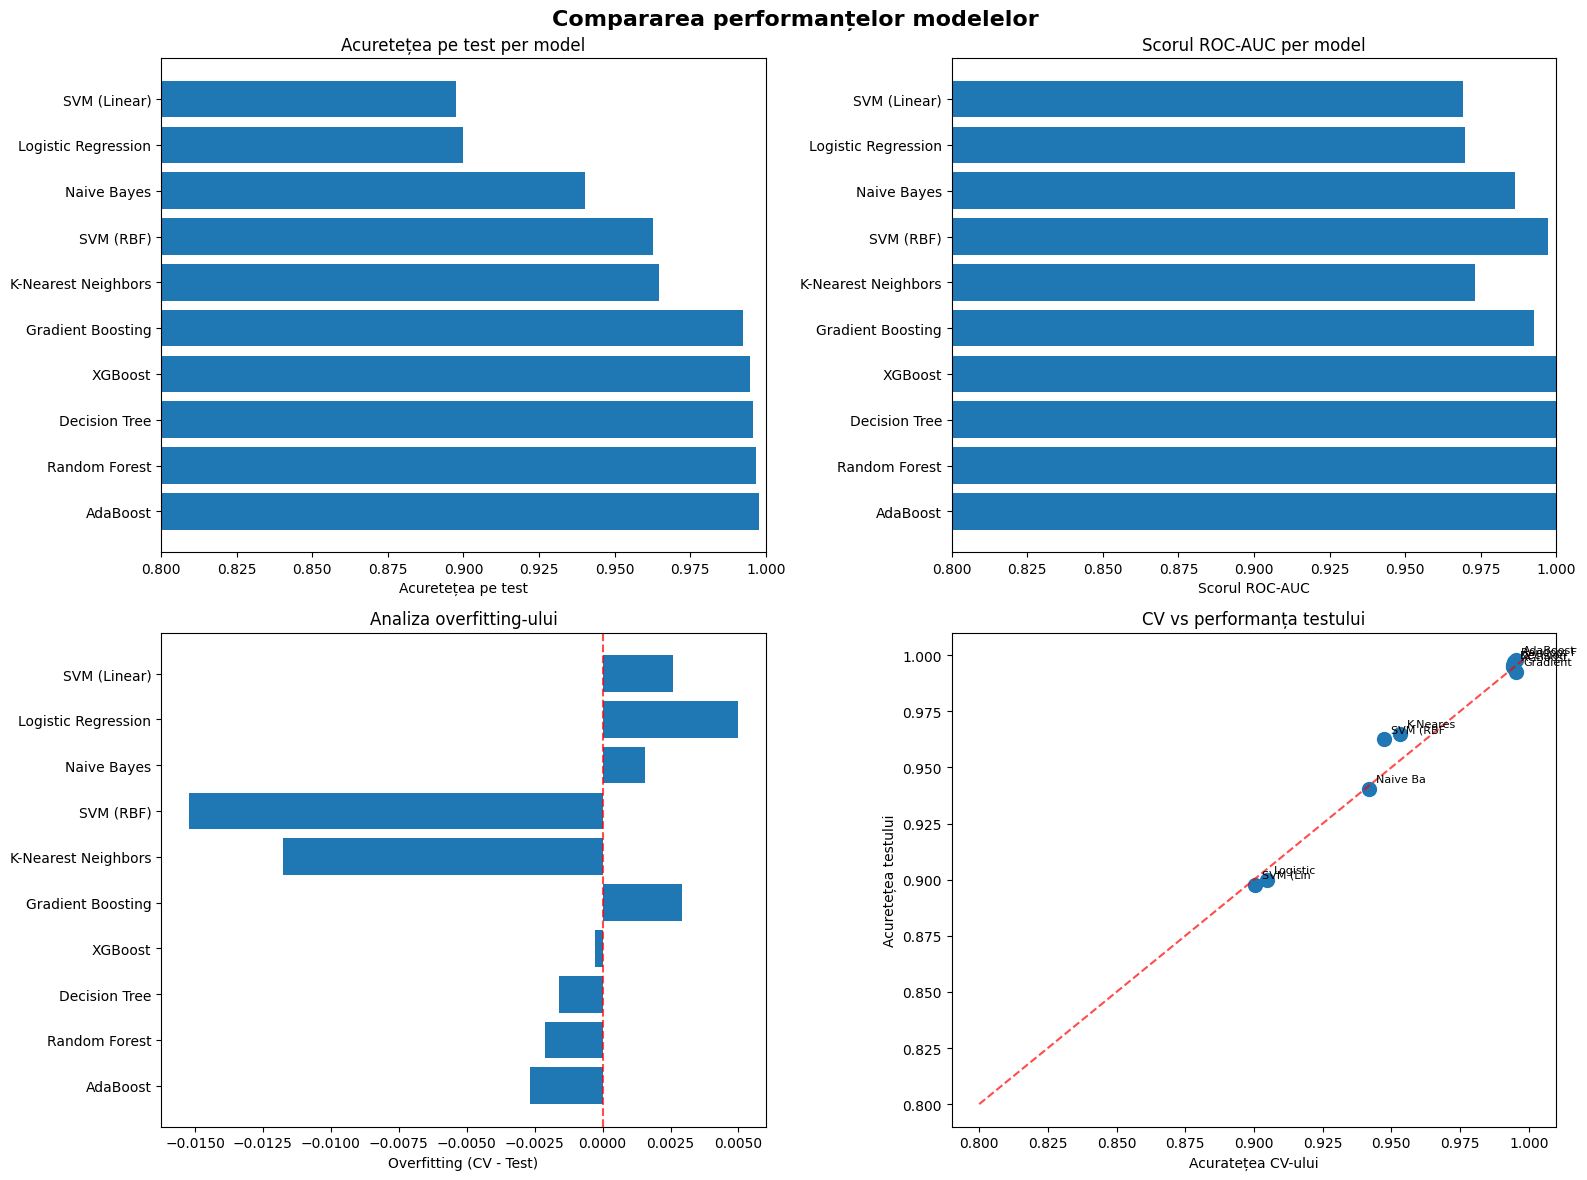

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Compararea performanțelor modelelor', fontsize=16, fontweight='bold')

# 1. Compararea acurateții pe setul de test
axes[0, 0].barh(results_df['Model'], results_df['Test_Accuracy'])
axes[0, 0].set_xlabel('Acuretețea pe test')
axes[0, 0].set_title('Acuretețea pe test per model')
axes[0, 0].set_xlim(0.8, 1.0)

# 2. Compararea ROC-AUC
roc_data = results_df[results_df['ROC_AUC'] > 0]
axes[0, 1].barh(roc_data['Model'], roc_data['ROC_AUC'])
axes[0, 1].set_xlabel('Scorul ROC-AUC')
axes[0, 1].set_title('Scorul ROC-AUC per model')
axes[0, 1].set_xlim(0.8, 1.0)

# 3. Analiza overfitting-ului
axes[1, 0].barh(results_df['Model'], results_df['Overfitting'])
axes[1, 0].set_xlabel('Overfitting (CV - Test)')
axes[1, 0].set_title('Analiza overfitting-ului')
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 4. CV Score vs Test Score
axes[1, 1].scatter(results_df['CV_Mean'], results_df['Test_Accuracy'], s=100)
for i, model in enumerate(results_df['Model']):
    axes[1, 1].annotate(model[:8], 
                       (results_df.iloc[i]['CV_Mean'], results_df.iloc[i]['Test_Accuracy']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 1].plot([0.8, 1.0], [0.8, 1.0], 'r--', alpha=0.7)
axes[1, 1].set_xlabel('Acuratețea CV-ului')
axes[1, 1].set_ylabel('Acuretețea testului')
axes[1, 1].set_title('CV vs performanța testului')

plt.tight_layout()
plt.show()

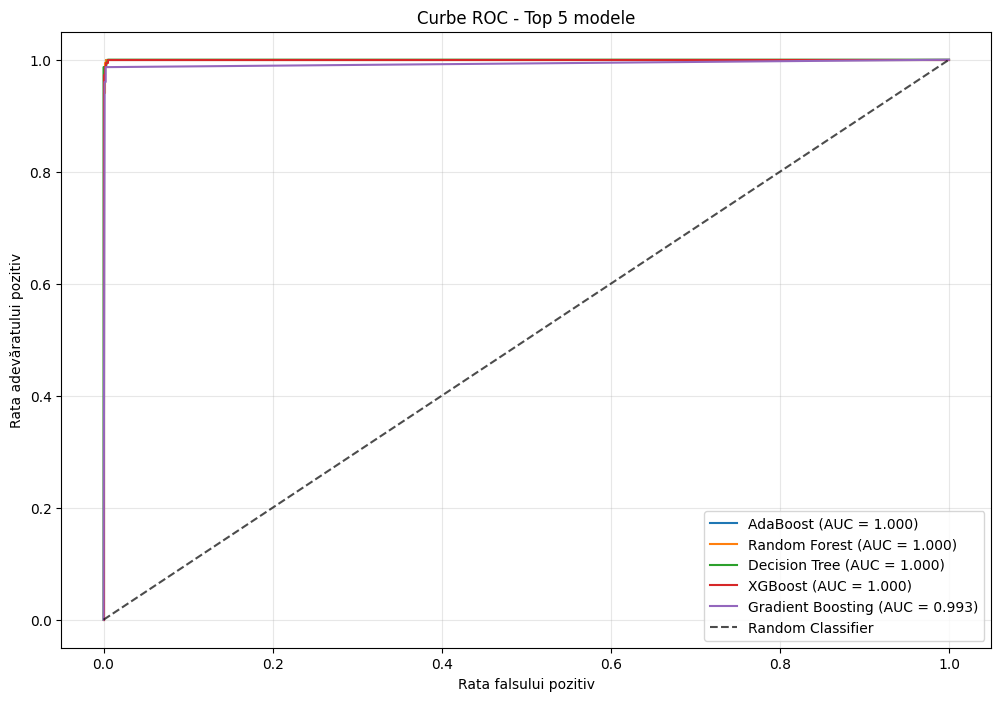

In [51]:
# ROC Curves for top models
plt.figure(figsize=(12, 8))
top_models = results_df.head(5)['Model'].tolist()

for model_name in top_models:
    if results[model_name]['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[model_name]['y_pred_proba'])
        auc_score = results[model_name]['test_roc_auc']
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Random Classifier')
plt.xlabel('Rata falsului pozitiv')
plt.ylabel('Rata adevăratului pozitiv')
plt.title('Curbe ROC - Top 5 modele')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Curbele de învățare pentru toate modelele

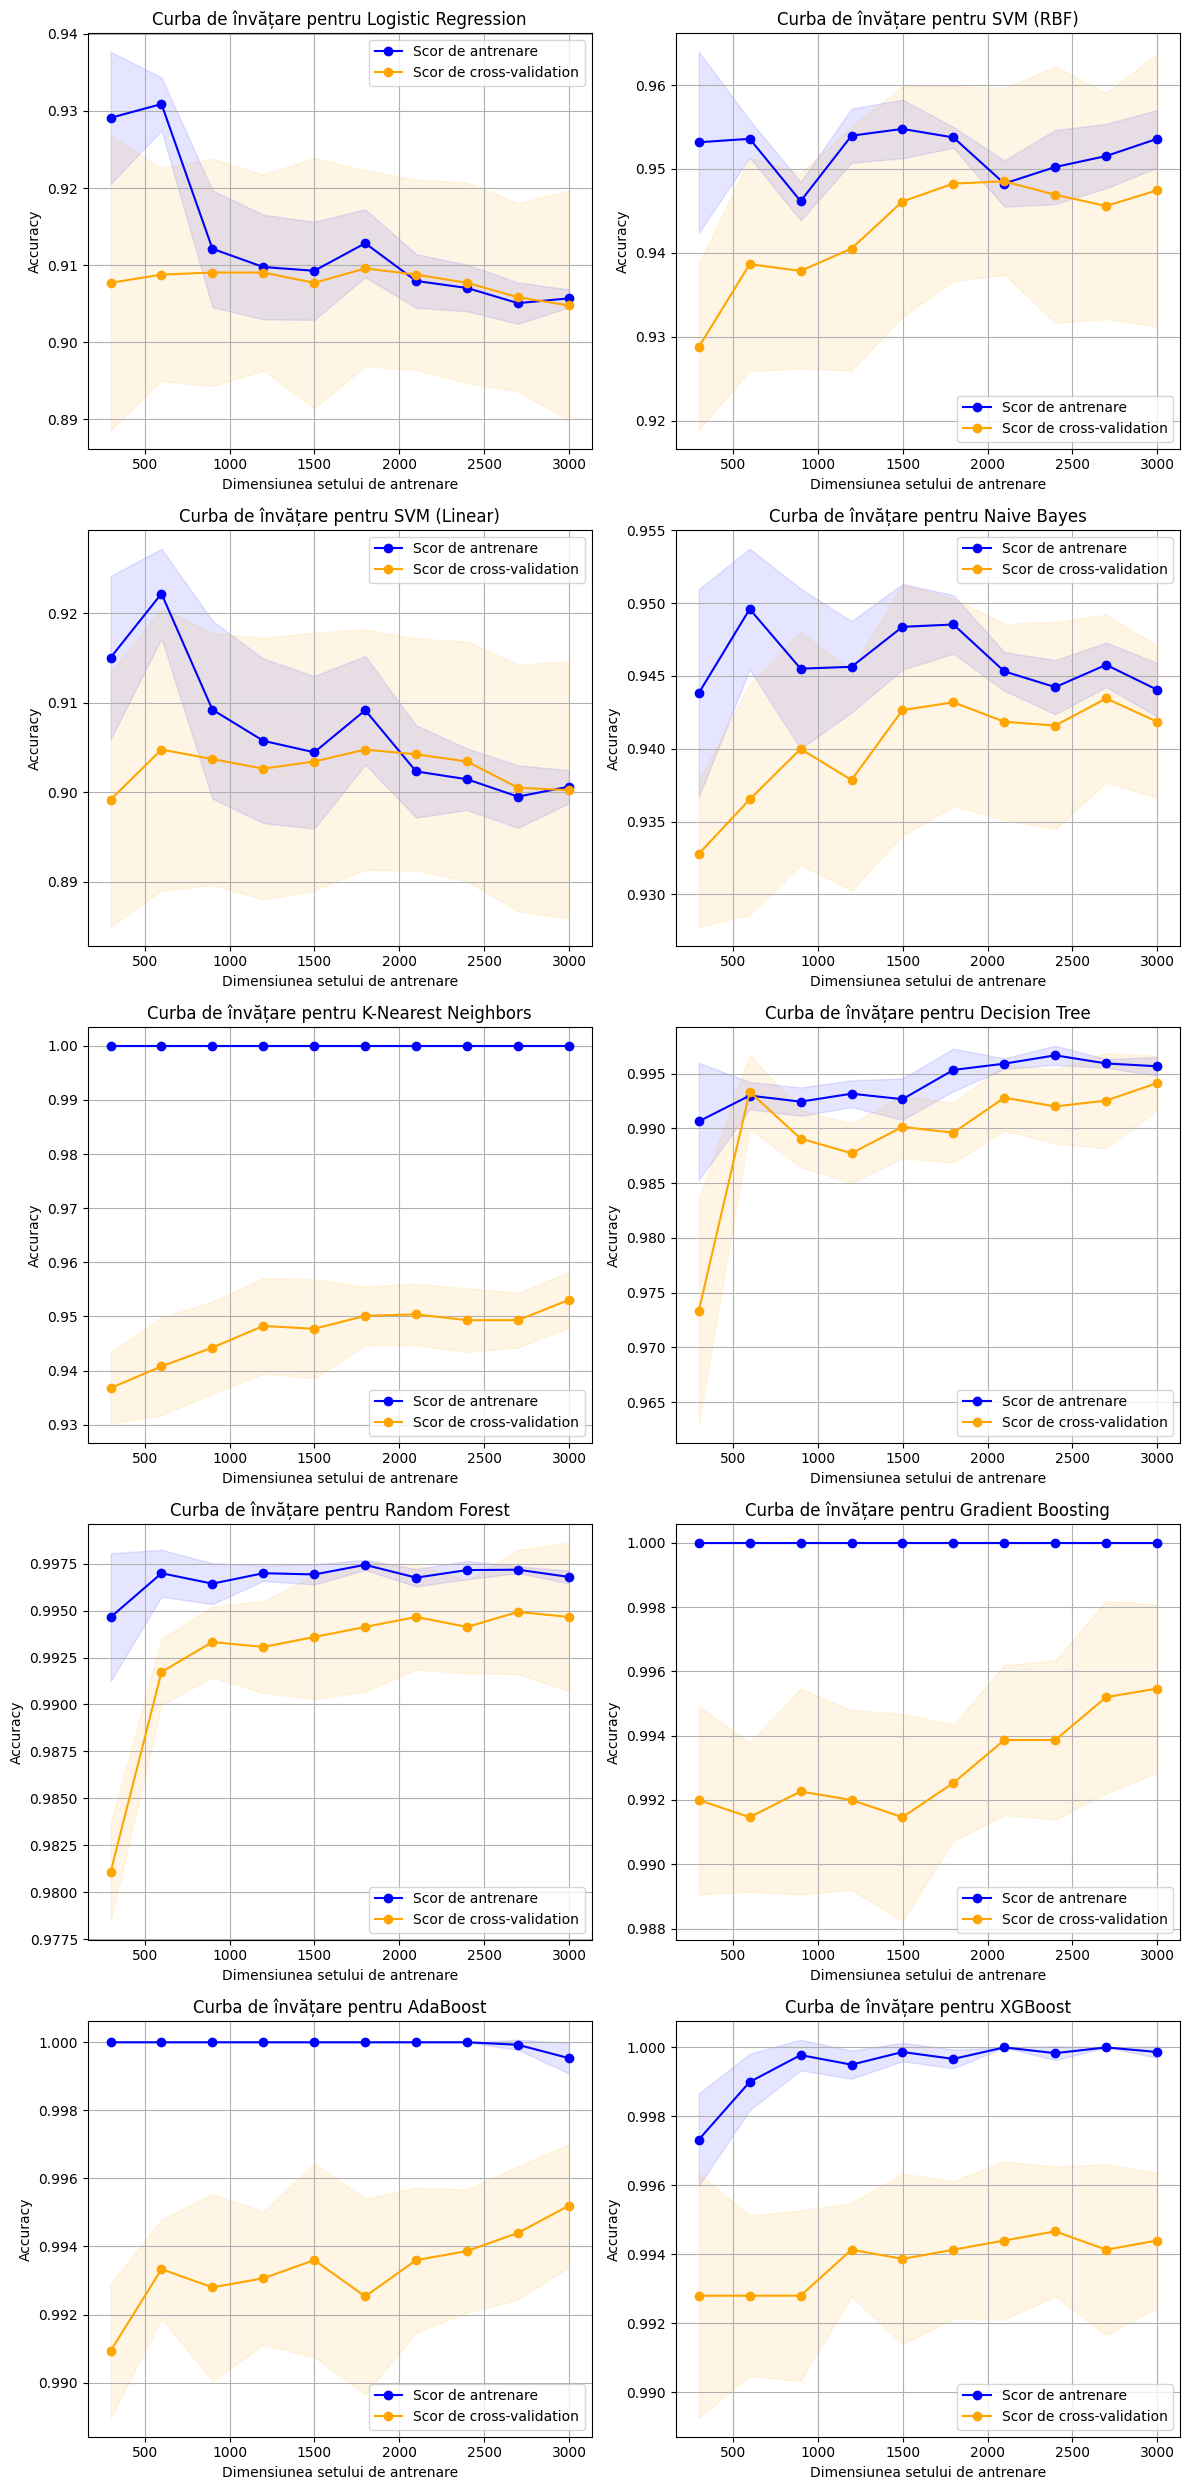

In [52]:
def plot_learning_curve_grid(models, X, y, cv=5, scoring='accuracy', n_jobs=-1):
    n_models = len(models)
    n_cols = 2
    n_rows = (n_models + 1) // n_cols  # Numărul de rânduri necesar

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten()  # Comprimat în cazul mai multor rânduri

    for idx, (model_name, estimator) in enumerate(models.items()):
        train_sizes, train_scores, valid_scores = learning_curve(
            estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs,
            train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        valid_mean = np.mean(valid_scores, axis=1)
        valid_std = np.std(valid_scores, axis=1)
        
        ax = axes[idx]
        ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Scor de antrenare')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

        ax.plot(train_sizes, valid_mean, 'o-', color='orange', label='Scor de cross-validation')
        ax.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='orange')

        ax.set_title(f"Curba de învățare pentru {model_name}")
        ax.set_xlabel('Dimensiunea setului de antrenare')
        ax.set_ylabel(scoring.capitalize())
        ax.legend(loc='best')
        ax.grid(True)
    
    # Dacă sunt subploțiuri goale, le ascundem
    for j in range(idx + 1, n_rows * n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_learning_curve_grid(models, X_train_final, y_train, cv=cv_strategy)

Matricea de confuzie

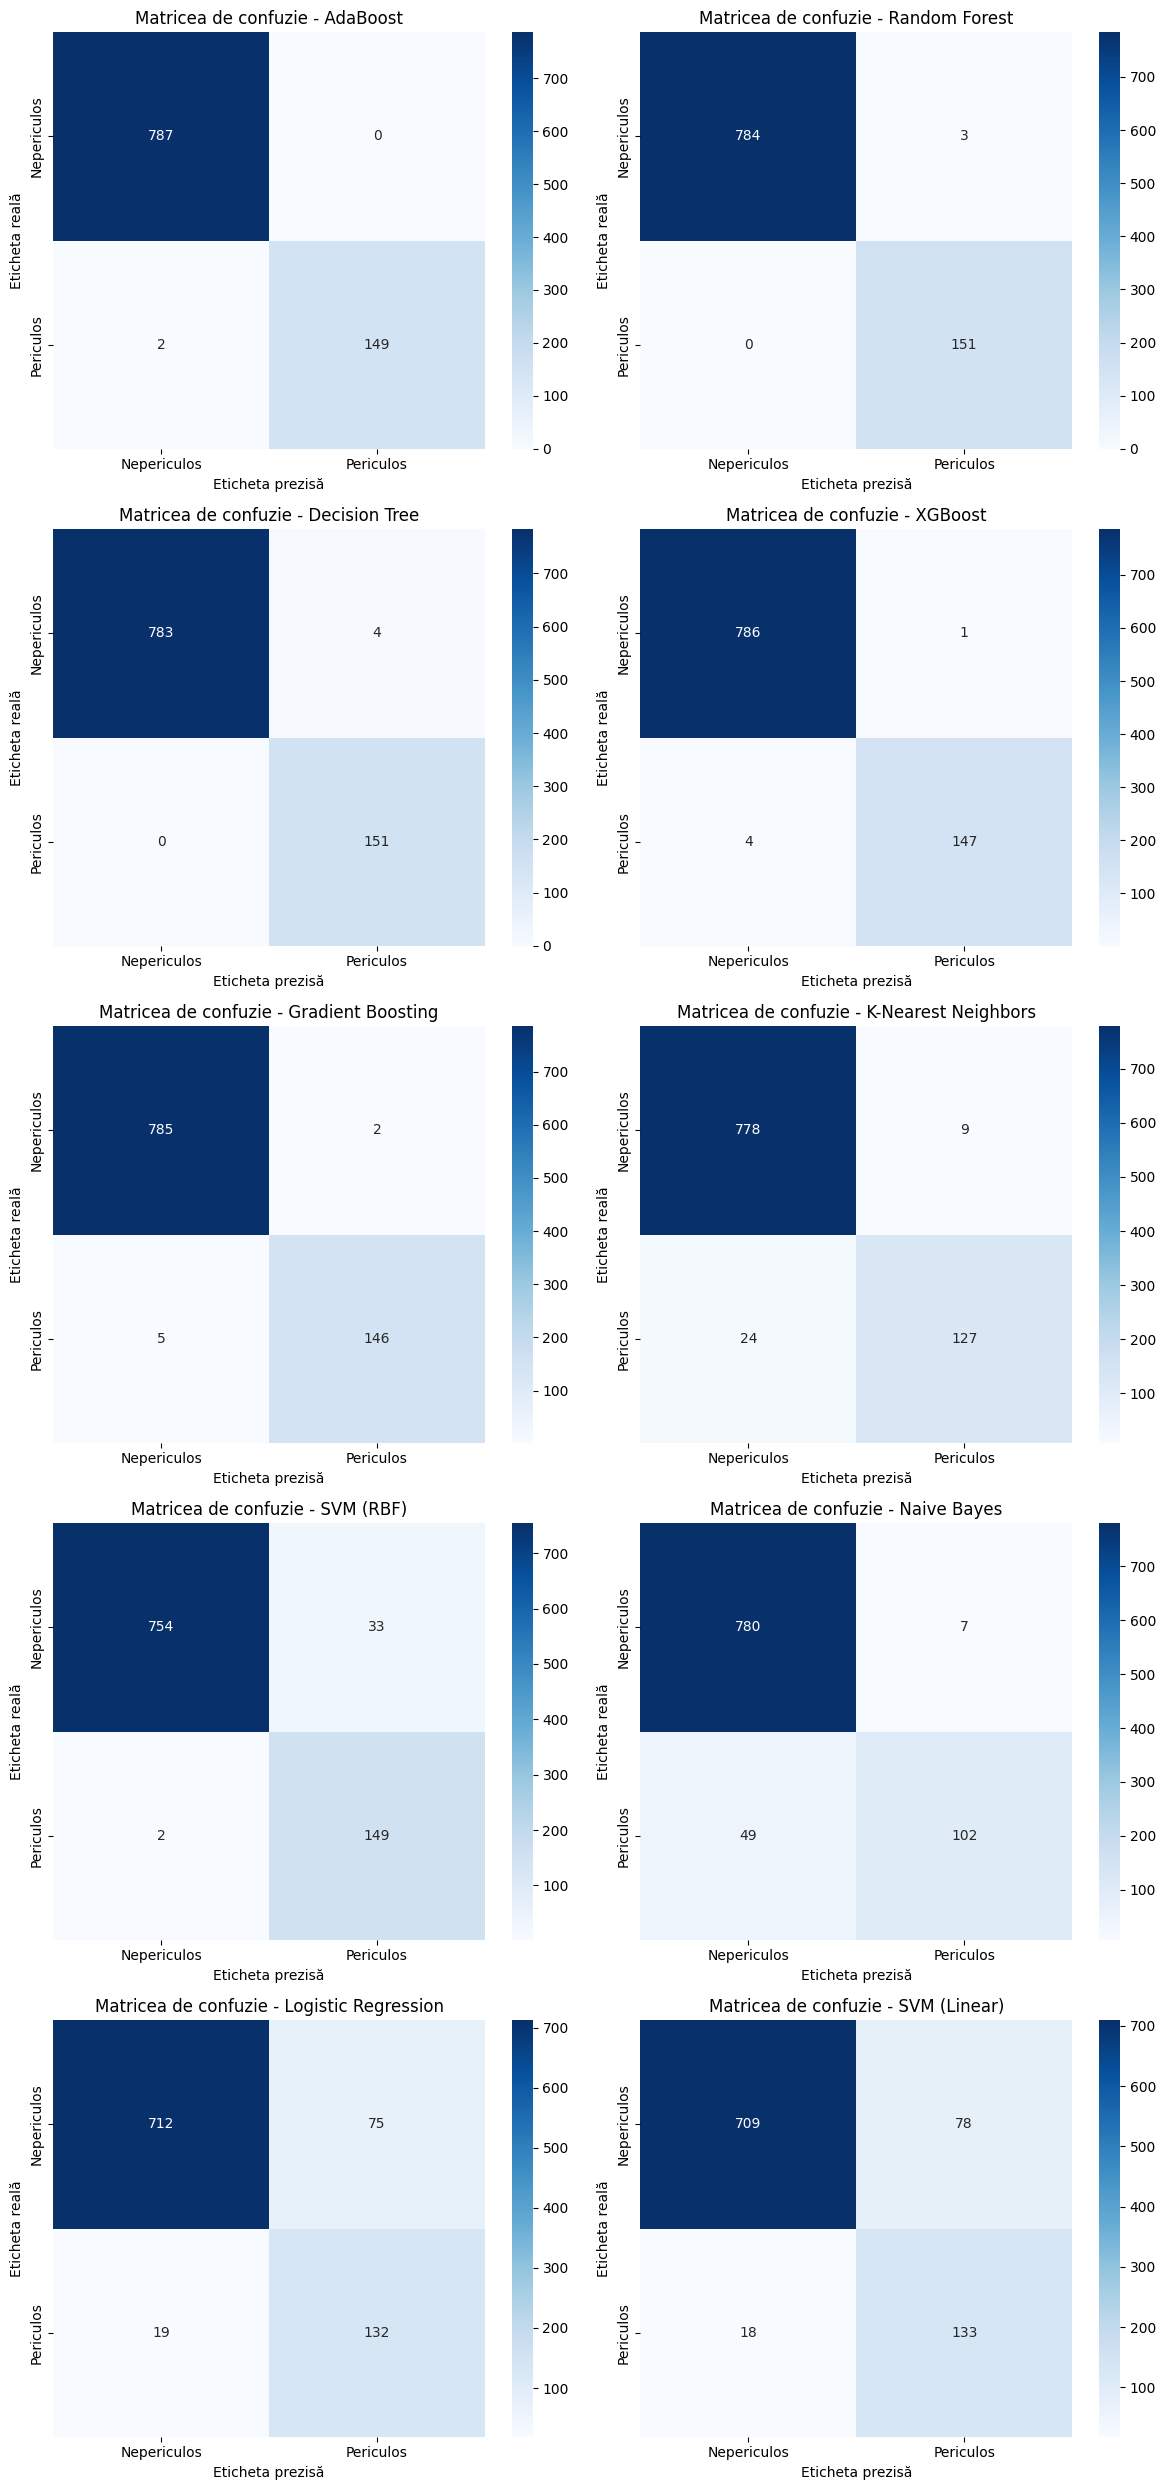

In [53]:
n_models = len(results_df)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)

plt.figure(figsize=(n_cols * 6, n_rows * 5))  # Ajustarea per total al dimensiunilor figurii

for idx, model_name in enumerate(results_df['Model']):
    y_pred = results[model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Nepericulos', 'Periculos'],
                yticklabels=['Nepericulos', 'Periculos'])
    plt.title(f'Matricea de confuzie - {model_name}')
    plt.ylabel('Eticheta reală')
    plt.xlabel('Eticheta prezisă')

plt.tight_layout()
plt.show()

Alegerea celui mai bun model

In [54]:
best_model_name = 'Random Forest'
best_model_result = results[best_model_name]

print(f"\nCel mai bun model: {best_model_name}")
print("="*50)
print(f"Acuratețea testării: {best_model_result['test_accuracy']:.4f}")
print(f"ROC-AUC: {best_model_result['test_roc_auc']:.4f}")
print(f"Acuratețea CV-ului: {best_model_result['cv_mean']:.4f} (+/- {best_model_result['cv_std']*2:.4f})")

print("\nRaport de clasificare detaliat:")
print(classification_report(y_test, best_model_result['y_pred']))


Cel mai bun model: Random Forest
Acuratețea testării: 0.9968
ROC-AUC: 0.9999
Acuratețea CV-ului: 0.9947 (+/- 0.0079)

Raport de clasificare detaliat:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       787
           1       0.98      1.00      0.99       151

    accuracy                           1.00       938
   macro avg       0.99      1.00      0.99       938
weighted avg       1.00      1.00      1.00       938



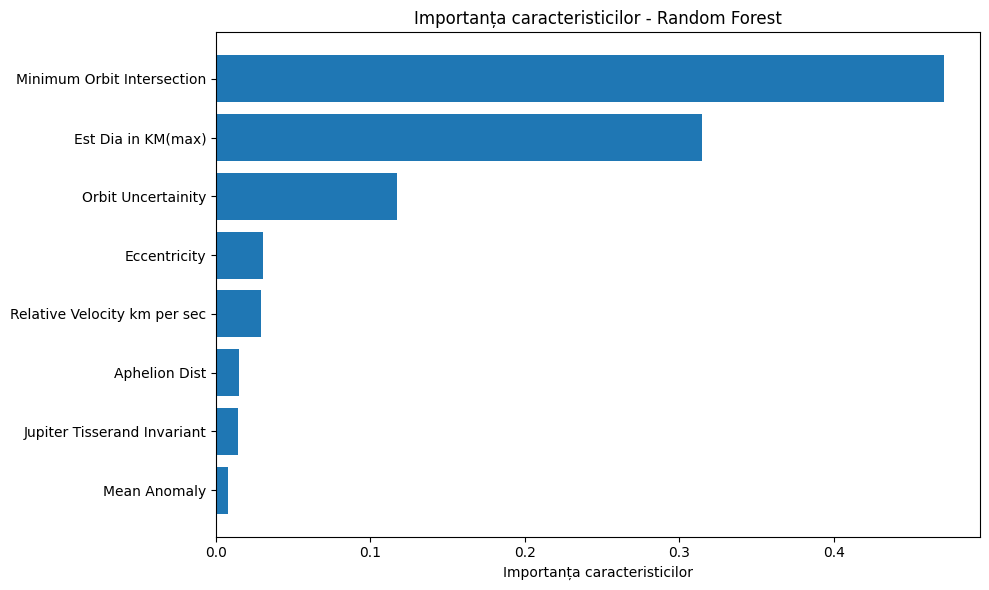

(3749, 8)
(3749,)


In [55]:
# Importanța caracteristicilor (dacă sunt disponibile)
if hasattr(best_model_result['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': best_model_result['model'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importanța caracteristicilor')
    plt.title(f'Importanța caracteristicilor - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

print(X_train_final.shape)
print(y_train.shape)

### 8. Implementarea

Ultima evaluare

In [56]:
# Hyperparameter tuning pentru cel mai bun model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 5]
    }
elif best_model_name == 'SVM (RBF)':
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.001, 0.01]
    }
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
else:
    param_grid = {}

if param_grid:
    print(f"Performing hyperparameter tuning for {best_model_name}...")
    
    base_model = models[best_model_name]
    grid_search = GridSearchCV(
        base_model, param_grid, cv=3, scoring='accuracy', 
        n_jobs=-1, verbose=0
    )
    
    grid_search.fit(X_train_final, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Stadiul final al modelului
    final_model = grid_search.best_estimator_
else:
    final_model = best_model_result['model']

final_pred = final_model.predict(X_test_final)
final_accuracy = (final_pred == y_test).mean()

print(f"\nPerformanța finală a modelului:\n")
print(f"Ultimul test de acuratețe: {final_accuracy:.4f}")

if hasattr(final_model, 'predict_proba'):
    final_proba = final_model.predict_proba(X_test_final)[:, 1]
    final_auc = roc_auc_score(y_test, final_proba)
    print(f"Ultimul test de ROC-AUC: {final_auc:.4f}")

print("\n\nRaportul final de clasificare:")
print(classification_report(y_test, final_pred))

Performing hyperparameter tuning for Random Forest...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score: 0.9965

Performanța finală a modelului:

Ultimul test de acuratețe: 0.9968
Ultimul test de ROC-AUC: 0.9999


Raportul final de clasificare:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       787
           1       0.98      1.00      0.99       151

    accuracy                           1.00       938
   macro avg       0.99      1.00      0.99       938
weighted avg       1.00      1.00      1.00       938



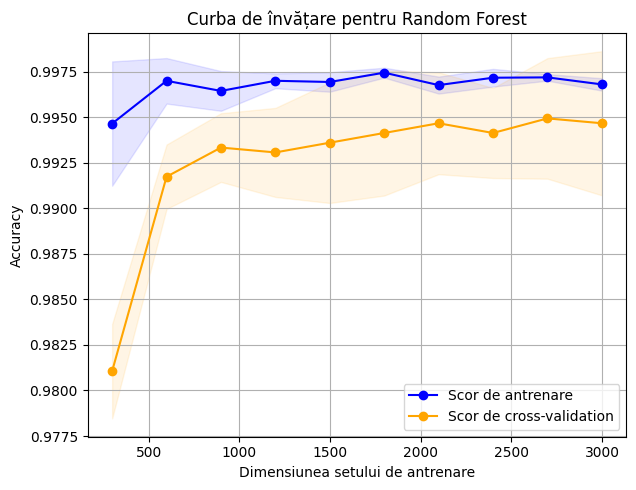

In [57]:
best_model = {}
best_model['Random Forest'] = models['Random Forest']
plot_learning_curve_grid(best_model, X_train_final, y_train, cv=cv_strategy)

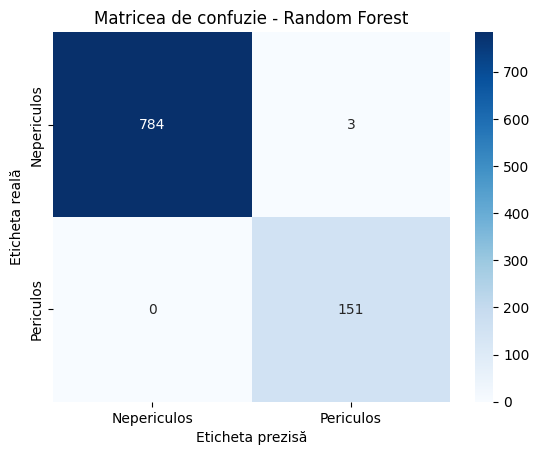

In [58]:
cm = confusion_matrix(y_test, final_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Nepericulos', 'Periculos'],
            yticklabels=['Nepericulos', 'Periculos'])
plt.title('Matricea de confuzie - Random Forest')
plt.ylabel('Eticheta reală')
plt.xlabel('Eticheta prezisă')

plt.show()

Implementarea efectivă

In [59]:
joblib.dump(final_model, "asteroid_model.pkl")
joblib.dump(best_scaler, "scaler.pkl")

['scaler.pkl']

Testarea mini-aplicației independente

In [60]:
import aplicatie_Crainiciuc_Filaret_Niculai as app

# Primele 10 observații sunt chiar din dataset, iar ultimele sunt generate de ChatGPT
# Ordinea valorilor corecte/sugerate de ChatGPT este:
#
# Periculos      1.
# Periculos      2.
# Periculos      3.
# Periculos      4.
# Periculos      5.
# Nepericulos    6.
# Nepericulos    7.
# Nepericulos    8.
# Nepericulos    9.
# Nepericulos    10.
#
# Periculos      11.
# Nepericulos    12.
# Periculos      13.
# Periculos      14.
# Nepericulos    15.
# Nepericulos    16.


input_data = """
1.290446,0.035523,0.412095,211.130108,0.450858,17.071768,0.537258,6.454
3.632314,0.038299,0.603479,286.455638,0.820427,25.395431,0.898228,3.346
1.191069,0.001793,0.235798,252.334226,0.342011,15.874281,0.736541,6.220
1.783220,0.018843,0.497346,134.878572,0.899580,11.244177,0.598621,5.199
2.293102,0.025757,0.559761,285.859380,3.342258,19.179113,0.647222,4.415
1.261097,0.121410,0.279491,34.470771,0.682402,13.084256,0.710150,6.090
3.591294,0.236907,0.603279,276.466281,0.517654,27.424918,0.888642,3.158
1.048520,0.051852,0.047854,327.973239,0.124177,19.123430,0.952751,5.976
5.291914,0.381816,0.611155,218.504766,0.326618,30.994787,1.277179,2.196
2.823943,0.298510,0.635693,359.929822,0.714562,16.998229,0.628959,3.861
2.1,0.045,0.62,210.0,0.95,23.5,0.79,3.0
1.1,0.17,0.22,67.4,0.2,8.5,0.85,6.3
1.3,0.033,0.58,145.2,1.2,27.0,0.55,2.85
3.5,0.011,0.66,310.5,0.75,29.1,0.7,3.2
5.2,0.19,0.41,102.0,0.3,14.8,2.1,5.6
2.8,0.25,0.34,250.3,0.4,11.2,1.9,4.9
"""

with open("sample_input.txt", "w") as f:
    f.write(input_data.strip())

app.predict_from_file()

Nepericulos
Nepericulos
Nepericulos
Nepericulos
Nepericulos
Nepericulos
Nepericulos
Periculos
Nepericulos
Nepericulos
Nepericulos
Nepericulos
Nepericulos
Nepericulos
Nepericulos
Nepericulos


c:\Users\Filu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
c:\Users\Filu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Filu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
c:\Users\Filu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Filu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\valida

### 9. Concluzii

### 10. Referințe

### 11. Anexa